Get geo-data
- Copy "Political Borders" dataset (already cleaned) from https://fraunhofercl-my.sharepoint.com/:f:/g/personal/apv_fraunhofer_cl/Elrh9GArWx1IqfpL9Es9_RUBsMLESVrMKfBYVWdsA-sdqg?e=D57lTk to "data\\political_borders\\"

For every region:
- Download "Uso de suelo" datasets for all regions from https://sit.conaf.cl/ and store in folder "data\\catastro_conaf\\"
- Import "Clase de suelo" REST datasets from https://esri.ciren.cl/server/rest/services/ESTUDIO_AGROLOGICO_SUELOS/MapServer in QGIS and save as .shp in folder "data\\clase_uso_suelo\\"
- Copy "Castro Fruticola" datasets (poly) for all regions from https://fraunhofercl-my.sharepoint.com/:f:/g/personal/apv_fraunhofer_cl/EiChxWxWTJ5CvZDy70T6QIYBiwxo4o6D1lQivNhOREpG7g?e=EP3Iha to folder "data\\catastro_fruticulture\\"

Script runs under python 3.9.12

In [11]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


0 - Import of libaries and configuration of file names

In [1]:
import pandas as pd
import geopandas as gpd
import importlib
import requests

from shapely.geometry import Point
import matplotlib.pyplot as plt

c:\Users\0davi\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\_compat.py:154: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()
C:\Users\0davi\AppData\Local\Temp\ipykernel_1404\1172264417.py:2: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


In [2]:
import av_potential_utils as av
importlib.reload(av)

<module 'av_potential_utils' from 'c:\\Users\\0davi\\github\\CSET_AV_Chile\\av_potential_utils.py'>

In [3]:
# Configuration
crs = 32719                 # For measurements in m
crs_illustration = 4326     # For illustration purposes, the most recognizable CRS


In [4]:
# CONSTANT FILE NAMES (DATA FOR all of CHILE)
file_name_borders = "Chile_regions_conti.shp"

# CHANGE NAME TO NAME OF SPECIFIC NAME OF .shp FILE FOR CURRENT REGION
file_name_clase_suelo = "clase_suelo_RM.shp"
file_name_fruti = "Región Metropolitana de Santiago_poly.shp"
file_name_conaf = "13__regi_n_metropolitana_2013.shp"

# CHOOSE NAME OF CURRENT REGION FROM FOLLOWING LIST:
# 'Aysén del General Carlos Ibáñez del Campo' 'Maule' 'Antofagasta'
# 'La Araucanía' "O'Higgins" 'Atacama' 'Valparaíso' 'Los Lagos' 'Biobío'
# 'Tarapacá' 'Metropolitana de Santiago' 'Los Ríos' 'Arica y Parinacota'
# 'Ñuble' 'Coquimbo'
region =  "Metropolitana de Santiago"

1 - Import of data and data perparation

1.1 Chile map

In [5]:
# import of shapefile of Chilean continental regions 
gdf_cl = gpd.read_file("data\\political_borders\\"+file_name_borders).to_crs(epsg = crs) 
gdf_cl = gdf_cl.rename(columns={'REGION': 'region'})

# Exclude Magallanes y de la Antártica Chilena (no potential + high computing time)
gdf_cl = gdf_cl[gdf_cl["region"] != "Magallanes y de la Antártica Chilena"] 
if region is not None:
    gdf_cl = gdf_cl[gdf_cl["region"] == region]

gdf_cl.to_file("processed\\"+region+".shp")
gdf_cl

,CUT_REG,region,SUPERFICIE,geometry
11,13,Metropolitana de Santiago,15401.94,"POLYGON ((331378.254 6241505.224, 333949.502 6..."


1.2 - Land use clases

In [6]:
gdf_cs = gpd.read_file("data\\clase_uso_suelo\\"+file_name_clase_suelo).to_crs(epsg = crs) 
gdf_cs["land_class"] = gdf_cs["textcaus"] 
av.get_area_shp(gdf_cs,unit="ha",column_name="area")
gdf_cs = gdf_cs[["land_class","area", "geometry"]]
# gdf_cs = gdf_cs[gdf_cs["land_class"].isin(['I', 'II', 'III', 'IV', 'V','VI','VII'])]  # Eclude non classified soil
gdf_cs.to_file("processed\\gdf_cs_rm.shp")
gdf_cs.head(3)

,land_class,area,geometry
0,II,545.78,"POLYGON ((303956.214 6261298.376, 303963.970 6..."
1,VII,4698.23,"POLYGON ((293516.736 6242445.581, 293542.142 6..."
2,VII,5850.19,"POLYGON ((287806.975 6252829.538, 287807.944 6..."


1.3 - Agricultural Areas

In [7]:
# Fruticultural Areas
gdf_fruti = gpd.read_file("data\\catastro_fruticulture\\"+file_name_fruti).to_crs(epsg = crs) 
av.get_area_shp(gdf_fruti,unit="ha",column_name="area")
gdf_fruti["agri_type"] = "permanent crops"
try:
    gdf_fruti["crop"] = gdf_fruti["ESPECIE"]
except:
    try:
        gdf_fruti["crop"] = gdf_fruti["Name"]
    except:
        print("crop type not found")
gdf_fruti["region"] = region
gdf_fruti["id"] = gdf_fruti.index
gdf_fruti = gdf_fruti[["id","agri_type","crop","region","area","geometry"]]
area_fruti_original = gdf_fruti["area"].sum().round(2)
print("The total area of the fruticultural ground is "+str(area_fruti_original)+" ha")

# Overlay with land use class
gdf_fruti_overlay = gpd.overlay(gdf_fruti, gdf_cs[["land_class","geometry"]], how='intersection')
av.get_area_shp(gdf_fruti_overlay,unit="ha",column_name="area")
area_fruti = gdf_fruti_overlay["area"].sum()
print("After overlay, the total area of the fruticultural ground is "+str(area_fruti)+" ha, difference of "+str((area_fruti-area_fruti_original).round(2))+" ha") 
gdf_fruti = gdf_fruti_overlay[["id","land_class","agri_type","crop","region","area","geometry"]]
gdf_fruti = gdf_fruti.sort_values(by='id')
gdf_fruti = gdf_fruti.reset_index(drop=True)
gdf_fruti

The total area of the fruticultural ground is 58686.37 ha
After overlay, the total area of the fruticultural ground is 58431.91 ha, difference of -254.46 ha


,id,land_class,agri_type,crop,region,area,geometry
0,0,I,permanent crops,NOGAL,Metropolitana de Santiago,1.06,"POLYGON ((335082.198 6261996.047, 335154.824 6..."
1,0,I,permanent crops,NOGAL,Metropolitana de Santiago,8.10,"POLYGON ((334809.657 6261641.026, 334703.775 6..."
2,1,I,permanent crops,NOGAL,Metropolitana de Santiago,7.24,"POLYGON ((334356.469 6261439.923, 334418.856 6..."
3,2,I,permanent crops,NOGAL,Metropolitana de Santiago,1.67,"POLYGON ((335525.318 6261732.629, 335521.838 6..."
4,2,I,permanent crops,NOGAL,Metropolitana de Santiago,8.95,"POLYGON ((335651.474 6261541.877, 335514.212 6..."
...,...,...,...,...,...,...,...
19739,12512,I,permanent crops,NOGAL,Metropolitana de Santiago,9.02,"POLYGON ((334703.775 6261701.924, 334809.657 6..."
19740,12513,I,permanent crops,NOGAL,Metropolitana de Santiago,7.48,"POLYGON ((334877.667 6261221.888, 334955.543 6..."
19741,12514,I,permanent crops,NOGAL,Metropolitana de Santiago,7.24,"POLYGON ((334883.845 6261598.182, 334927.406 6..."
19742,12515,I,permanent crops,NOGAL,Metropolitana de Santiago,7.04,"POLYGON ((335298.428 6261406.525, 335280.621 6..."


In [8]:
# Agricultural Areas
gdf_conaf = gpd.read_file("data\\catastro_conaf\\"+file_name_conaf).to_crs(epsg = crs) 

#gdf_conaf = gdf_conaf[['USO', 'SUBUSO', 'ESTRUCTURA', 'COBERTURA', 'CODREG','NOM_REG',
#       'NOM_COM10','NOM_PRO10', 'SUPERF_HA','geometry']]
        
gdf_agri = gdf_conaf[gdf_conaf['USO']=='TERRENOS AGRICOLAS']            # Filter for agricultural areas
av.get_area_shp(gdf_agri,unit="ha")
area_agri_original = gdf_agri["area"].sum()
print("The total area of the agricultural ground is "+str(area_agri_original)+" ha")
gdf_agri["agri_type"] = "arable land"
gdf_agri["area_of"] = gdf_agri["SUPERF_HA"]
gdf_agri["crop"] = gdf_agri["SUBUSO"]
gdf_agri["region"] = gdf_agri["NOM_REG"]

gdf_agri = gdf_agri[["agri_type","crop","region","area","geometry"]]

# Cut out fruticulture orchard areas
gdf_agri["area_old"] = gdf_agri["area"].copy()
gdf_agri_cut = gpd.overlay(gdf_agri, gdf_fruti, how='difference')
av.get_area_shp(gdf_agri_cut,unit="ha")
area_agri = gdf_agri_cut["area"].sum()
print("After cutting fruticultural ground, the total area of the agricultural ground is "+str(area_agri)+" ha, difference of "+str(area_agri-area_agri_original)+" ha")

# Clean columns
gdf_agri = gdf_agri_cut.reset_index(drop=True)
gdf_agri["id"] = gdf_agri.index
gdf_agri = gdf_agri[["id","agri_type","crop","region","area","geometry"]]

# Overlay with land use class
gdf_agri_overlay = gpd.overlay(gdf_agri, gdf_cs, how='intersection')
av.get_area_shp(gdf_agri_overlay,unit="ha",column_name="area")
area_agri_overlay =gdf_agri_overlay["area"].sum()
print("After overlay, the total area of the agricultural ground is "+str(area_agri_overlay)+" ha, difference of "+str((area_agri_overlay-area_agri).round(2))+" ha") 

gdf_agri = gdf_agri_overlay[["id","land_class","agri_type","crop","region","area","geometry"]]
gdf_agri = gdf_agri.sort_values(by='id')
gdf_agri = gdf_agri.reset_index(drop=True)
gdf_agri.head(3)

The total area of the agricultural ground is 219103.02000000002 ha
After cutting fruticultural ground, the total area of the agricultural ground is 164307.19 ha, difference of -54795.830000000016 ha
After overlay, the total area of the agricultural ground is 163218.61000000002 ha, difference of -1088.58 ha


,id,land_class,agri_type,crop,region,area,geometry
0,0,II,arable land,TERRENOS DE USO AGRICOLA,Region Metropolitana de Santiago,14.98,"POLYGON ((309080.000 6272410.000, 309079.020 6..."
1,0,VI,arable land,TERRENOS DE USO AGRICOLA,Region Metropolitana de Santiago,2.50,"MULTIPOLYGON (((309060.000 6272450.000, 309060..."
2,1,IV,arable land,TERRENOS DE USO AGRICOLA,Region Metropolitana de Santiago,4.99,"POLYGON ((314175.041 6271648.169, 314179.990 6..."


In [9]:
gdf_agri_fruti = pd.concat([gdf_agri,gdf_fruti])
gdf_agri_fruti = gdf_agri_fruti.reset_index(drop=True)
gdf_agri_fruti["id"] = gdf_agri_fruti.index
gdf_agri_fruti.to_file("processed\\gdf_agri_"+region+".shp")
gdf_agri_fruti.head(3)

,id,land_class,agri_type,crop,region,area,geometry
0,0,II,arable land,TERRENOS DE USO AGRICOLA,Region Metropolitana de Santiago,14.98,"POLYGON ((309080.000 6272410.000, 309079.020 6..."
1,1,VI,arable land,TERRENOS DE USO AGRICOLA,Region Metropolitana de Santiago,2.50,"MULTIPOLYGON (((309060.000 6272450.000, 309060..."
2,2,IV,arable land,TERRENOS DE USO AGRICOLA,Region Metropolitana de Santiago,4.99,"POLYGON ((314175.041 6271648.169, 314179.990 6..."


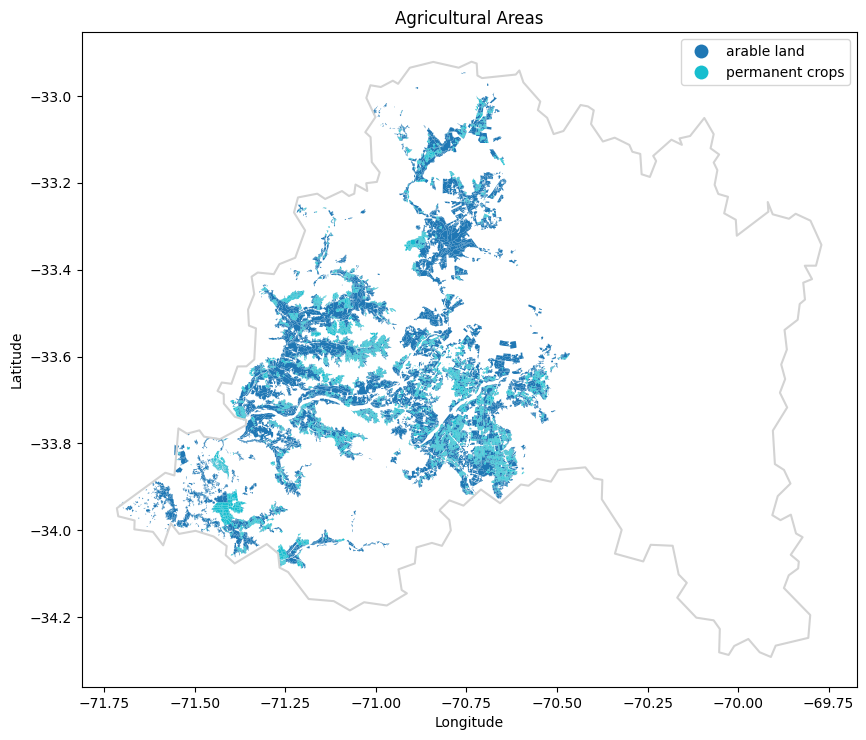

In [10]:
# Plot agricultural areas
ax = gdf_agri_fruti.to_crs(crs_illustration).plot(figsize=(10, 10), column='agri_type', legend=True)
gdf_cl.to_crs(crs_illustration).boundary.plot(ax=ax, edgecolor="lightgrey")

plt.title("Agricultural Areas")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()